# Analyse final shaft temperature
In this notebook I will analyse the extracted corrected shaft temperature. I dont think these will be my final true temperature estimations, but I dont expect to change these values much.

In [1]:
import pickle
import pandas as pd
import statistics
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
from shutil import copy2 as copy_file
import matplotlib.dates as mdates

from my_func_mvw.functions import read_pickle, calc_stat_of_difference, statistic_plot

# TO DO
# Knickpunkt am Anfang von Schacht über Zeit konstant? Beginnt Schacht erst danach?
# single ended lines korrekturen

# Trend in vergleich von up und down:
# Abschnittweise besser?
# channel 5 und 6 dieser plot angucken



######################### Input ######################################################
#path to my_database - if downloaded from sciebo change it to r".\\"
path = r"..\Alsdorf\Daten\my_database" # r"..\Alsdorf\Daten\my_database" ".\\"
#what file format should be used for import
importer="pickel" #csv pickel
# for some plots I use plotly.express, you may need to install that. 
# You can set the following to False if you dont want to see them.
show_big_plots = False #True False
######################################################################################
#the following inputs are rather only for me, if you want to use them you need to adjust some additional pathts
plot_save = False # True False

if show_big_plots:
    import plotly
    import plotly.express as px
    import kaleido
# Install plotly:
# If using conda as package manager: open anaconda prommpt and exexute: conda install -c plotly plotly
# restarting the notebook is not neccessary
# Install Kaleido: - used for saving plotly plots
# If using conda: conda install -c conda-forge python-kaleido


print("Some Version information of the imported packages")
print(f"pandas: {pd.__version__}")
print(f"pickle: {pickle.format_version}")
!python --version
# my output:
# Some Version information of the imported packages
# pandas: 1.2.3
# pickle: 4.0
# Python 3.8.8

Some Version information of the imported packages
pandas: 1.3.2
pickle: 4.0
Python 3.8.11


In [2]:
#Import Data
# import pickle
path_to_my_database_pickle = path + r"\shaft_final_temperature\egrt_cable\pickle"
if importer=="pickel":
    filename=f"\\Schacht_7and8_down"
    Schacht_7and8_down=read_pickle(path_to_my_database_pickle+filename)
    filename=f"\\Schacht_7and8_up"
    Schacht_7and8_up=read_pickle(path_to_my_database_pickle+filename)

#import csv
path_to_my_database_csv = path + r"\shaft_final_temperature\egrt_cable\csv"
if importer=="csv":
    filename=f"\\Schacht_7and8_down.csv"
    Schacht_7and8_down=pd.read_csv(path_to_my_database_csv+filename,index_col=0)
    Schacht_7and8_down.index   = pd.to_datetime(Schacht_7and8_down.index, infer_datetime_format=True)
    Schacht_7and8_down.columns = Schacht_7and8_down.columns.astype(int)
    Schacht_7and8_down.columns.names = ["Depth [m]"]

    filename=f"\\Schacht_7and8_up.csv"
    Schacht_7and8_up=pd.read_csv(path_to_my_database_csv+filename,index_col=0)
    Schacht_7and8_up.index   = pd.to_datetime(Schacht_7and8_up.index, infer_datetime_format=True)
    Schacht_7and8_up.columns = Schacht_7and8_up.columns.astype(int)
    Schacht_7and8_up.columns.names = ["Depth [m]"]

# Accuracy of Data - I did not yet create this table for the constshift data!!!!!
determined with my notebook `analyse_my_databse_alsdorf.ipynb`. In the other notebook these table belongs to the shiftfirst values. The values of channel 7 and 8 are the values corresponding to the imported data here.  The data imported here is from the first shaft section, which is between the first two watertank positions. The first watertank position ist used as reference (due to the shiftfirst method its not zero at this position). Around the bendpoint in the shaft the data of channel 5 and 6 has higher inaccuracies, therfore they are not imported here. Although they have slightly better statistics at the watertank positions.

[//]: # "when using this script in script folder:"
<img src=".\pictures\tables\mean_stdev_shiftfirst.png" alt="Statistic of Temperature difference in watertank" title="when using this script in my script folder" />

[//]: # "when using this script in my_database:"
<img src=".\overview_plots\mean_stdev_shiftfirst.png" alt="Statistic of Temperature difference in watertank" title="when using this script in my_database" />

*Side Note: The import of this picture is not optimal, because I added two import lines for two different paths. Locally I have all my scripts in a central repository, I copy this from there when uploading to sciebo.*

I assume a standart deviation of 0.22 for the complete data imported in this notebook.
# I am not sure what about the mean shift, how incooperate it in data accuracy estimation
at the moment I dont incooperate it


In [3]:
# up und down sind nicht perfekt auf einander abgestimmt von der Tiefe. 
# Eine perfekte Abstimmung wird man nie erreichen, da es nur diskrete Messpunkte gibt. 
# D.h. die der Index, also die Tiefenangaben zu den Temperaturen sind nicht ganz richtig.

# Dies liegt daran, dass ich entlang des Kabels mir die ABstände raus suche, bei denen ich denke, dass der Schacht beginnt. 
# Dieses Auswählen muss ich so machen, dass das Kabel hoch unf runter genau gleich viele Messpunkte hat. 
# Die Messpunkte von hoch und runter sind aber natürlich nicht notwendigerweise auf der gleichen Höhe, 
# da der Umknickpunkt nicht auf die Messpunkte abgestimmt ist und die ersten (bzw letzen) Messpunkt nicht exakt bei 0 sind.

# Im Moment ist der Fehler aber noch größer als er sein sollte würde ich sagen

# Test um zu gucken wie die Differenz zwischen up und down verändert werden kann
# # Daten so verändern, dass sich differenzen zwischen den Tiefen minimiert
# #bei beiden immer gleich viele Messpunkte weg nehemen

# drop x first value of the one dataset and x values at the end of the other
# x=4
# #Schacht_7and8_up = Schacht_7and8_up[Schacht_7and8_down.columns[:-x]]
# #Schacht_7and8_down = Schacht_7and8_down[Schacht_7and8_down.columns[x:]]

# Schacht_7and8_down = Schacht_7and8_down[Schacht_7and8_down.columns[x:]]
# Schacht_7and8_up = Schacht_7and8_up[Schacht_7and8_up.columns[x:]]

In [4]:
# copied from my_database script, maybe I should add it to my_func_mvw
def plot_save_func(filename_save):
    """saves the plots as png and copies them to my_database"""
    save_path = "pictures/" + filename_save + ".png"
    save_path_dpi720 = "pictures/dpi720/" + filename_save + "_dpi_720.png"
    plt.savefig(save_path)
    plt.savefig(save_path_dpi720, dpi=720)
    # copy pictures to my_database
    save_to = r"..\Alsdorf\Daten\my_database\overview_plots"
    save_to_dpi720 = r"..\Alsdorf\Daten\my_database\overview_plots\dpi720"
    copy_file(save_path, save_to)
    copy_file(save_path_dpi720, save_to_dpi720)

In [5]:
# Plot the data
#https://plotly.com/python-api-reference/generated/plotly.express.imshow.html
plot="you dont want this plot"
if show_big_plots:
    plot = px.imshow(Schacht_7and8_down,labels={"color":"Temperature"},zmin=15,zmax=35,
                    title="Avearage Channel 7 and 8 shaft, down")
if plot_save and show_big_plots:
    #https://plotly.com/python/static-image-export/
    path = r"..\Alsdorf\Daten\my_database\overview_plots"
    filename = "\carpet_final_temperature_EGRT-Cable_down.png"
    plot.write_image(path + filename)
    # exports the plot as html, so the hover features are avaible
    filename = "\carpet_live_final_temperature_EGRT-Cable_down.html"
    plotly.offline.plot(plot, filename=path + filename)
plot
# looks the same
#px.imshow(Schacht_7and8_up,labels={"color":"Temperature"},zmin=15,zmax=35,title="Avearage Channel 7 and 8 shaft, up")

'you dont want this plot'

In [6]:
# Plot Difference between up and down
diff_up_down = Schacht_7and8_down - Schacht_7and8_up
if show_big_plots:
    plot=px.imshow(diff_up_down,labels={"color":"Difference"},zmin=-1,zmax=1, title="Difference of up and down")
plot

'you dont want this plot'

In [7]:
# calc mean and standart deviation for every depth

diff_statistic = calc_stat_of_difference(diff_up_down)
stdev_mean=diff_statistic.loc["stdev"].mean()

## Improvement
At the moment you see a small trend in the difference of the up and down temperature. I think its due to a slightly wrong shaft position. I think I need to shift one side for less than one meter (diskretisation is 1 m at the moment). This could be done with interpolation between the points. So that the up and down data belong to the exact same position. This should increase the similiarity of up and down. (doing this would somewhat be changing the data so that they show what I expect / want them to show.)

When assuming that the measurements belong exactly the same depth, I would expect a difference in the range of the standart deviation, with a constant mean. As shown in the plot below, the standart deviation is the expected range but the mean is not.

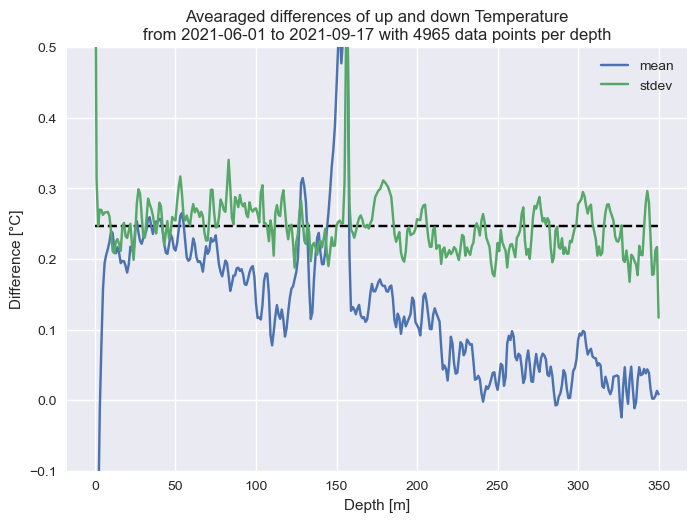

In [8]:
# Plot Difference Statistics

plt.plot(diff_statistic.loc["mean"].index,diff_statistic.loc["mean"].values,label="mean")
plt.plot(diff_statistic.loc["stdev"].index,diff_statistic.loc["stdev"].values,label="stdev")
plt.hlines([stdev_mean],0,350,color="black",linestyle="--")
plt.ylim(-0.1,0.5)
plt.xlabel("Depth [m]")
plt.ylabel("Difference [°C]")
plt.legend()
min_date = diff_up_down.index.min().strftime("%Y-%m-%d")
max_date = diff_up_down.index.max().strftime("%Y-%m-%d")
n = len(diff_up_down.index)
plt.title(f"Avearaged differences of up and down Temperature\nfrom {min_date} to {max_date} with {n} data points per depth")
plt.show()

#this trend is only seen in borehole, and not in the data outide. However the data outside have much more noise, so its hard tell. My conclusion is, that both indexes not perfectly fit each other.

# after water-table: sligthly increased standart deviation, with higher fluctuation

# if temp in water would be constant, I wouldnt expect a trend in the mean. I would expect a mean of 0 and a stdev like measured at the watertanks. --> we have a gradient in the water

# Behauptung: All measurement points of one side of the table are sligthly deeper than at the other.
 
# With a constant gradient, I would expect a const not zero value.
# with no gradient, I would expect a const mean value equal to 0.
# We see a non constant mean --> gradient not constant.
# --> ist kein Beweis, dass es den trend wegen der Behauptung gibt

In [13]:
# Both plots are very similar, for interpretation one of them is sufficient. Its just to show that they are very similar
# A lot of these plots is copied from Daniels plot from Alsdorf_plot.py

plot_up_down=False
if plot_up_down:
    depth = [Schacht_7and8_down.columns,Schacht_7and8_up.columns] # depth is the same for both
    # fore every depth minimum along all dates
    tempmin = [Schacht_7and8_down.min(axis = 0),Schacht_7and8_up.min(axis = 0)]
    tempmax = [Schacht_7and8_down.max(axis = 0),Schacht_7and8_up.max(axis = 0)]
    tempmean = [Schacht_7and8_down.mean(axis = 0),Schacht_7and8_up.mean(axis = 0)]
    tempstd = [Schacht_7and8_down.std(axis = 0),Schacht_7and8_up.std(axis = 0)]

    label_2 = 'Mean' 
    labelmin = 'Min - Max'
    labelstd = 'Standartdeviation'
    fig , axs=plt.subplots(1,2,figsize=[14,7], sharey = True,constrained_layout=True)
    fig.suptitle("Statisitc of Temperature Change over time",fontsize=14)
    for i in range(len(axs)):
        axs[i].plot(tempmean[i], depth[i], color='#10366f', alpha = 0.8, label = label_2)
        axs[i].fill_betweenx(depth[i], tempmin[i], tempmax[i],
                        #facecolor="blue",           # The fill color
                        color='#7fc7ff',             # The outline color
                        alpha=0.3, label = labelmin) # Transparency of the fill
        axs[i].fill_betweenx(depth[i], tempmean[i] - tempstd[i], tempmean[i] + tempstd[i],
                        # facecolor="#1CB992",       # The fill color
                        color="#c52b2f",             # The outline color
                        alpha=0.3, label = labelstd) # Transparency of the fill
        # axs[i].fill_betweenx(depth[i], tempmean[i] - 0.22, tempmean[i] + 0.22,
        #             # facecolor="#1CB992",       # The fill color
        #             color="black",             # The outline color
        #             alpha=0.3, label = "Expected Standartdeviation") # Transparency of the fill

        axs[i].set_ylim([(depth[i].max() + 0.05 * (depth[i].max()-depth[i].min())), 
                        (depth[i].min() - 0.05 * (depth[i].max() - depth[i].min()))])
        axs[i].legend()
        axs[i].set_ylabel("Depth [m]")
        axs[i].set_xlabel("Temperature [°C]")
        axs[i].set_xlim(18,28)

    axs[1].yaxis.set_ticks_position("right") 
    axs[1].yaxis.set_label_position("right") 
    axs[0].set_title("Down")
    axs[1].set_title("Up")
    if plot_save:
        plot_save_func("final_temperature_EGRT-Cable_up_and_down")
    plt.show()

# the shown standart deviation here is different from the one in the table! Here it shows the Varianz of the measurements over time. In other words this plots shows the stability of the system over time, measured with DTS.
# In the table it shows the Variance of the difference to the watertank temperature. These show how good the DTS measurements are.
# In a stable system it is expected, that both values are the same. In an not constant system the standart deviation over time is higher. The standart deviation of the difference to the true value should be the same --> wird noch genauer angeguckt mit Wassertank erhitzen.

# From the table above you can say that in 95 % of the measurements the true Temperature is in the range of 2*0.22=0.44 [°C]. Negleting that the mean difference is not zero. Adding this mean difference = +- 0.2 as a constant shift results in value range of +- 0.64 [°C]. 

# As long as the standart deviation is in the range of the expected deviation, it means there is no change in temperature over time, which is detectable with the DTS-device (due to the assumed accuracy).


# Plot 
Dort wird nur down dargestellt

5 dates with nan have been added


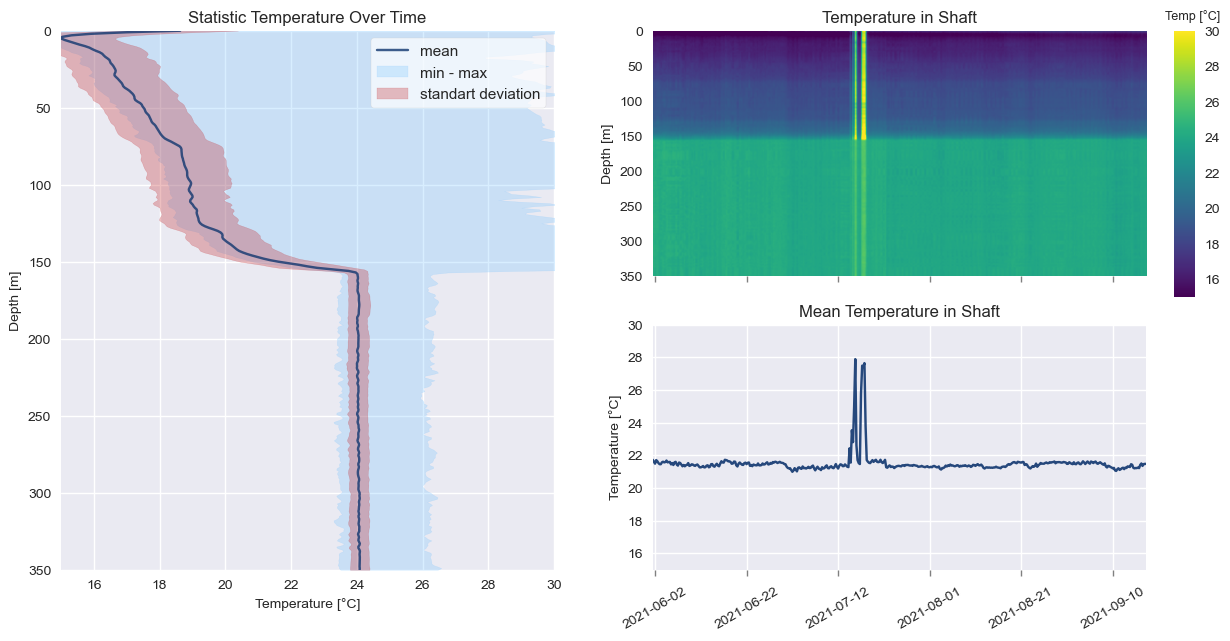

In [12]:
shaft_for_plot_func={}
channel="7and8down"
shaft_for_plot_func[channel] = Schacht_7and8_down
statistic_plot(data_shaft=shaft_for_plot_func,date_min_max=[0,-1],c=channel,temp_ax_min=15, temp_ax_max=30, sample_hours = 6)

if plot_save and channel == "7and8down":
    filename=f"\\temperature_in_shaft_chan{channel}_statistic"
    plt.savefig(r".\pictures" + filename + ".png", bbox_inches="tight")
    plt.savefig(r"..\Masterthesis_tex\figs\chap4" + filename + ".pdf", format="pdf",bbox_inches="tight")

plt.show()